1. over the full set of strategy QA rollouts, identify backtracking sentences. Get this count average per rollout.
2. compute activations for a subset
3. train a probe on the 10 tokens before the backtracking came. Do difference in means
4. get this probe accuracy on held out set of rollouts
5. try steer with this probe

# 1. over the full set of strategy QA rollouts, identify backtracking sentences

Loaded 1000 rollouts
Backtracking statistics:
  Mean: 2.44
  Std:  3.62
  Min:  0
  Max:  164


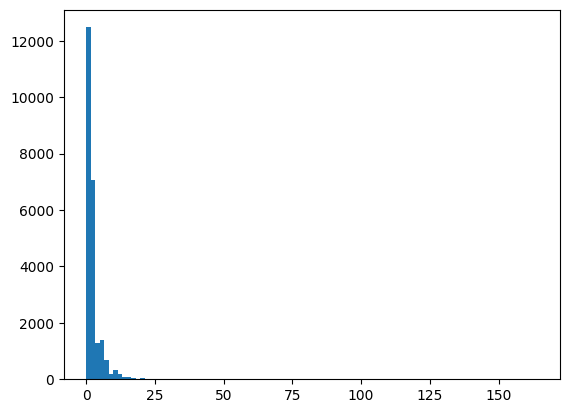

In [2]:
import json

# Load the StrategyQA rollouts data
with open('/workspace/basic_science_resampling/data/strategyqa_rollouts.json', 'r') as f:
    strategyqa_rollouts = json.load(f)

train_pct = 0.8
train_rollouts = strategyqa_rollouts[:int(len(strategyqa_rollouts) * train_pct)]
test_rollouts = strategyqa_rollouts[int(len(strategyqa_rollouts) * train_pct):]
print(f"Loaded {len(strategyqa_rollouts)} rollouts")

import numpy as np
all_backtracking_counts = []
for question_idx in range(len(train_rollouts)):
    rollouts = train_rollouts[question_idx]['model_outputs']
    backtracking_counts = [np.array(['wait' in sentence.lower() for sentence in rollout.split('.')]).sum() for rollout in rollouts]
    all_backtracking_counts.extend(backtracking_counts)



import matplotlib.pyplot as plt
all_backtracking_counts = np.array(all_backtracking_counts)
plt.hist(all_backtracking_counts, bins=100)
print(f"Backtracking statistics:")
print(f"  Mean: {all_backtracking_counts.mean():.2f}")
print(f"  Std:  {all_backtracking_counts.std():.2f}")
print(f"  Min:  {all_backtracking_counts.min()}")
print(f"  Max:  {all_backtracking_counts.max()}")

Probably want to only use rollouts with less than 20 wait sentences

# 2. compute activations for a subset

In [4]:
import json
from pipeline.rollout_generator import RolloutGenerator
# Load the strategyqa data
with open('/workspace/basic_science_resampling/data/strategyqa_data.json', 'r') as f:
    strategyqa_qns = json.load(f)

print(f"Loaded {len(strategyqa_qns)} questions from strategyqa_data.json")

import polars as pl
rollout_generator = RolloutGenerator()
for question in strategyqa_qns:
    question['formatted_prompt'] = rollout_generator.format_prompt(question['question'])
for rollouts, rollouts_name in [(train_rollouts, 'train_rollouts'), (test_rollouts, 'test_rollouts')]:
    rollouts_exploded = pl.DataFrame(strategyqa_qns).join(pl.DataFrame(rollouts), on='question_id', how='inner').explode('model_outputs')
    rollouts_exploded = pl.DataFrame(rollouts_exploded).rename(
        {
            'formatted_prompt': 'instruction',
            'model_outputs': 'response'
        }
    )
    # Randomly sample 1% of rollouts_exploded
    pct = 0.05
    sample_size = max(1, int(len(rollouts_exploded) * 0.05))  # Ensure at least 1 sample
    rollouts_exploded = rollouts_exploded.sample(n=sample_size, seed=42)
    print(f"Sampled {len(rollouts_exploded)} rollouts ({pct*100:.0f}% of original)")
    rollouts_exploded = rollouts_exploded.to_dicts()
    # Save the exploded train rollouts to JSON file

    with open(f'/workspace/basic_science_resampling/data/{rollouts_name}.json', 'w') as f:
        json.dump(rollouts_exploded, f, indent=2)

        print(f"Saved {len(rollouts_exploded)} exploded rollouts to {rollouts_name}.json")

Loaded 1603 questions from strategyqa_data.json
Sampled 1200 rollouts (5% of original)
Saved 1200 exploded rollouts to train_rollouts.json
Sampled 300 rollouts (5% of original)
Saved 300 exploded rollouts to test_rollouts.json


In [5]:
import importlib
import pipeline.store_activations
importlib.reload(pipeline.store_activations)
from pipeline.store_activations import load_and_validate_responses, format_responses_with_chat_template, store_activations

In [6]:
rollout_responses = load_and_validate_responses('/workspace/basic_science_resampling/data/test_rollouts.json')

2025-10-24 17:34:21,964 - INFO - Loading rollouts from: /workspace/basic_science_resampling/data/test_rollouts.json
2025-10-24 17:34:21,985 - INFO - Loaded and validated 300 responses


In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-8b')

In [8]:
formatted_responses = format_responses_with_chat_template(rollout_responses, tokenizer)

2025-10-24 17:34:25,661 - INFO - Formatted 300 responses with chat template


In [9]:
store_activations(
    model_name='Qwen/Qwen3-8b',
    rollouts_path='/workspace/basic_science_resampling/data/train_rollouts.json',
    activations_dir='/workspace/basic_science_resampling/data/activations/train/',
)

2025-10-24 17:34:29,542 - INFO - Loading rollouts from: /workspace/basic_science_resampling/data/train_rollouts.json
2025-10-24 17:34:29,604 - INFO - Loaded and validated 1200 responses
2025-10-24 17:34:29,605 - INFO - Loading tokenizer: Qwen/Qwen3-8b
2025-10-24 17:34:30,175 - INFO - Formatted 1200 responses with chat template
2025-10-24 17:34:30,178 - INFO - Activations will be saved to: /workspace/basic_science_resampling/data/activations/train/
2025-10-24 17:34:30,178 - INFO - Loading model: Qwen/Qwen3-8b
2025-10-24 17:34:30,930 - INFO - Processing 1200 responses (indices 0 to 1200)
2025-10-24 17:34:31,719 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

2025-10-24 17:34:35,103 - INFO - Queued activations for response 0
2025-10-24 17:34:35,604 - INFO - Queued activations for response 1
2025-10-24 17:34:35,604 - INFO - Saved activations to /workspace/basic_science_resampling/data/activations/train/0.pt
2025-10-24 17:34:36,085 - INFO - Queued activations for response 2
2025-10-24 17:34:36,312 - INFO - Saved activations to /workspace/basic_science_resampling/data/activations/train/1.pt
2025-10-24 17:34:36,508 - INFO - Queued activations for response 3
2025-10-24 17:34:36,824 - INFO - Saved activations to /workspace/basic_science_resampling/data/activations/train/2.pt
2025-10-24 17:34:37,243 - INFO - Queued activations for response 4
2025-10-24 17:34:37,243 - INFO - Saved activations to /workspace/basic_science_resampling/data/activations/train/3.pt
2025-10-24 17:34:37,714 - INFO - Queued activations for response 5
2025-10-24 17:34:37,946 - INFO - Saved activations to /workspace/basic_science_resampling/data/activations/train/4.pt
2025-10-

KeyboardInterrupt: 

# 3. Difference in means probe

In [3]:
import torch
from transformers import AutoTokenizer
import numpy as np

In [4]:
n_tokens_before_wait = 10
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-8b')

In [5]:
think_token_id = tokenizer.encode('<think>')[0]

In [6]:
# Get indices for n_tokens_before_wait before each wait token
def get_before_wait_indices(token_ids, n_tokens_before_wait):
    is_wait = np.array(['wait' in token_str.lower() for token_str in tokenizer.tokenize(tokenizer.decode(token_ids))])
    wait_indices = np.where(is_wait)[0]
    before_wait_indices = []
    for wait_idx in wait_indices:
        start_idx = max(0, wait_idx - n_tokens_before_wait)
        before_wait_indices.extend(range(start_idx, wait_idx))

    # Convert to numpy array and get unique indices (union)
    before_wait_indices = np.unique(before_wait_indices)

    # Get all other indices (complement of before_wait_indices)
    all_indices = np.arange(len(token_ids))
    # Find the first occurrence of think_token_id and slice from there
    think_token_idx = np.where(token_ids == think_token_id)[0]
    if len(think_token_idx) > 0:
        all_indices = all_indices[think_token_idx[0]:]
    all_other_indices = np.setdiff1d(all_indices, before_wait_indices)

    return before_wait_indices, all_other_indices

In [7]:
import glob

In [8]:
import gc
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
import threading

def process_activation_file(path):
    with torch.no_grad():
        print(f"Processing {path}")
        token_ids, activations = torch.load(path)
        before_wait_indices, all_other_indices = get_before_wait_indices(token_ids, n_tokens_before_wait)
        if len(before_wait_indices) > 0:
            before_wait = activations[:,before_wait_indices,:]
            all_other = activations[:,all_other_indices,:]
            
            # Calculate means for this batch
            before_wait_mean = before_wait.mean(dim=1)  # [n_layers, d_model]
            all_other_mean = all_other.mean(dim=1)      # [n_layers, d_model]
            
            # Clean up intermediate tensors
            del activations, token_ids, before_wait, all_other
            gc.collect()
            
            return before_wait_mean, all_other_mean, before_wait_indices.shape[0], all_other_indices.shape[0]
        
        # Clean up if no valid indices
        del activations, token_ids
        gc.collect()
        return None, None, 0, 0

# Initialize running means and counts with thread lock
before_wait_running_mean = None
all_other_running_mean = None
before_wait_total_count = 0
all_other_total_count = 0
update_lock = threading.Lock()

def update_running_means(before_wait_mean, all_other_mean, before_wait_count, all_other_count):
    global before_wait_running_mean, all_other_running_mean, before_wait_total_count, all_other_total_count
    
    with update_lock:
        if before_wait_mean is not None and all_other_mean is not None:
            # Update running mean for before_wait
            if before_wait_running_mean is None:
                before_wait_running_mean = before_wait_mean.clone()
            else:
                # Running mean update: new_mean = (old_mean * old_count + new_mean * new_count) / (old_count + new_count)
                total_before_wait = before_wait_total_count + before_wait_count
                before_wait_running_mean = (before_wait_running_mean * before_wait_total_count + before_wait_mean * before_wait_count) / total_before_wait
            
            # Update running mean for all_other
            if all_other_running_mean is None:
                all_other_running_mean = all_other_mean.clone()
            else:
                total_all_other = all_other_total_count + all_other_count
                all_other_running_mean = (all_other_running_mean * all_other_total_count + all_other_mean * all_other_count) / total_all_other
            
            # Update counts
            before_wait_total_count += before_wait_count
            all_other_total_count += all_other_count

paths = glob.glob('/workspace/basic_science_resampling/data/activations/train/*.pt')

# Process files in parallel
with ThreadPoolExecutor(max_workers=4) as executor:
    # Submit all tasks
    future_to_path = {executor.submit(process_activation_file, path): path for path in paths}
    
    # Process results as they complete
    for future in concurrent.futures.as_completed(future_to_path):
        path = future_to_path[future]
        try:
            before_wait_mean, all_other_mean, before_wait_count, all_other_count = future.result()
            update_running_means(before_wait_mean, all_other_mean, before_wait_count, all_other_count)
        except Exception as exc:
            print(f'{path} generated an exception: {exc}')

# Set final means
before_wait_activations_mean = before_wait_running_mean
all_other_activations_mean = all_other_running_mean

# Final cleanup
gc.collect()

Processing /workspace/basic_science_resampling/data/activations/train/1198.pt
Processing /workspace/basic_science_resampling/data/activations/train/1199.pt
Processing /workspace/basic_science_resampling/data/activations/train/1197.pt
Processing /workspace/basic_science_resampling/data/activations/train/1196.pt
Processing /workspace/basic_science_resampling/data/activations/train/1195.pt
Processing /workspace/basic_science_resampling/data/activations/train/1194.pt
Processing /workspace/basic_science_resampling/data/activations/train/1193.pt
Processing /workspace/basic_science_resampling/data/activations/train/1192.pt
Processing /workspace/basic_science_resampling/data/activations/train/1191.pt
Processing /workspace/basic_science_resampling/data/activations/train/1190.pt
Processing /workspace/basic_science_resampling/data/activations/train/1189.ptProcessing /workspace/basic_science_resampling/data/activations/train/1188.pt

Processing /workspace/basic_science_resampling/data/activations/

0

In [9]:
diff_vectors = before_wait_activations_mean - all_other_activations_mean

In [10]:
torch.save(diff_vectors, '/workspace/basic_science_resampling/data/diff_vectors.pt')

In [11]:
import einops
from einops import einsum
import torch

In [12]:
import matplotlib.pyplot as plt

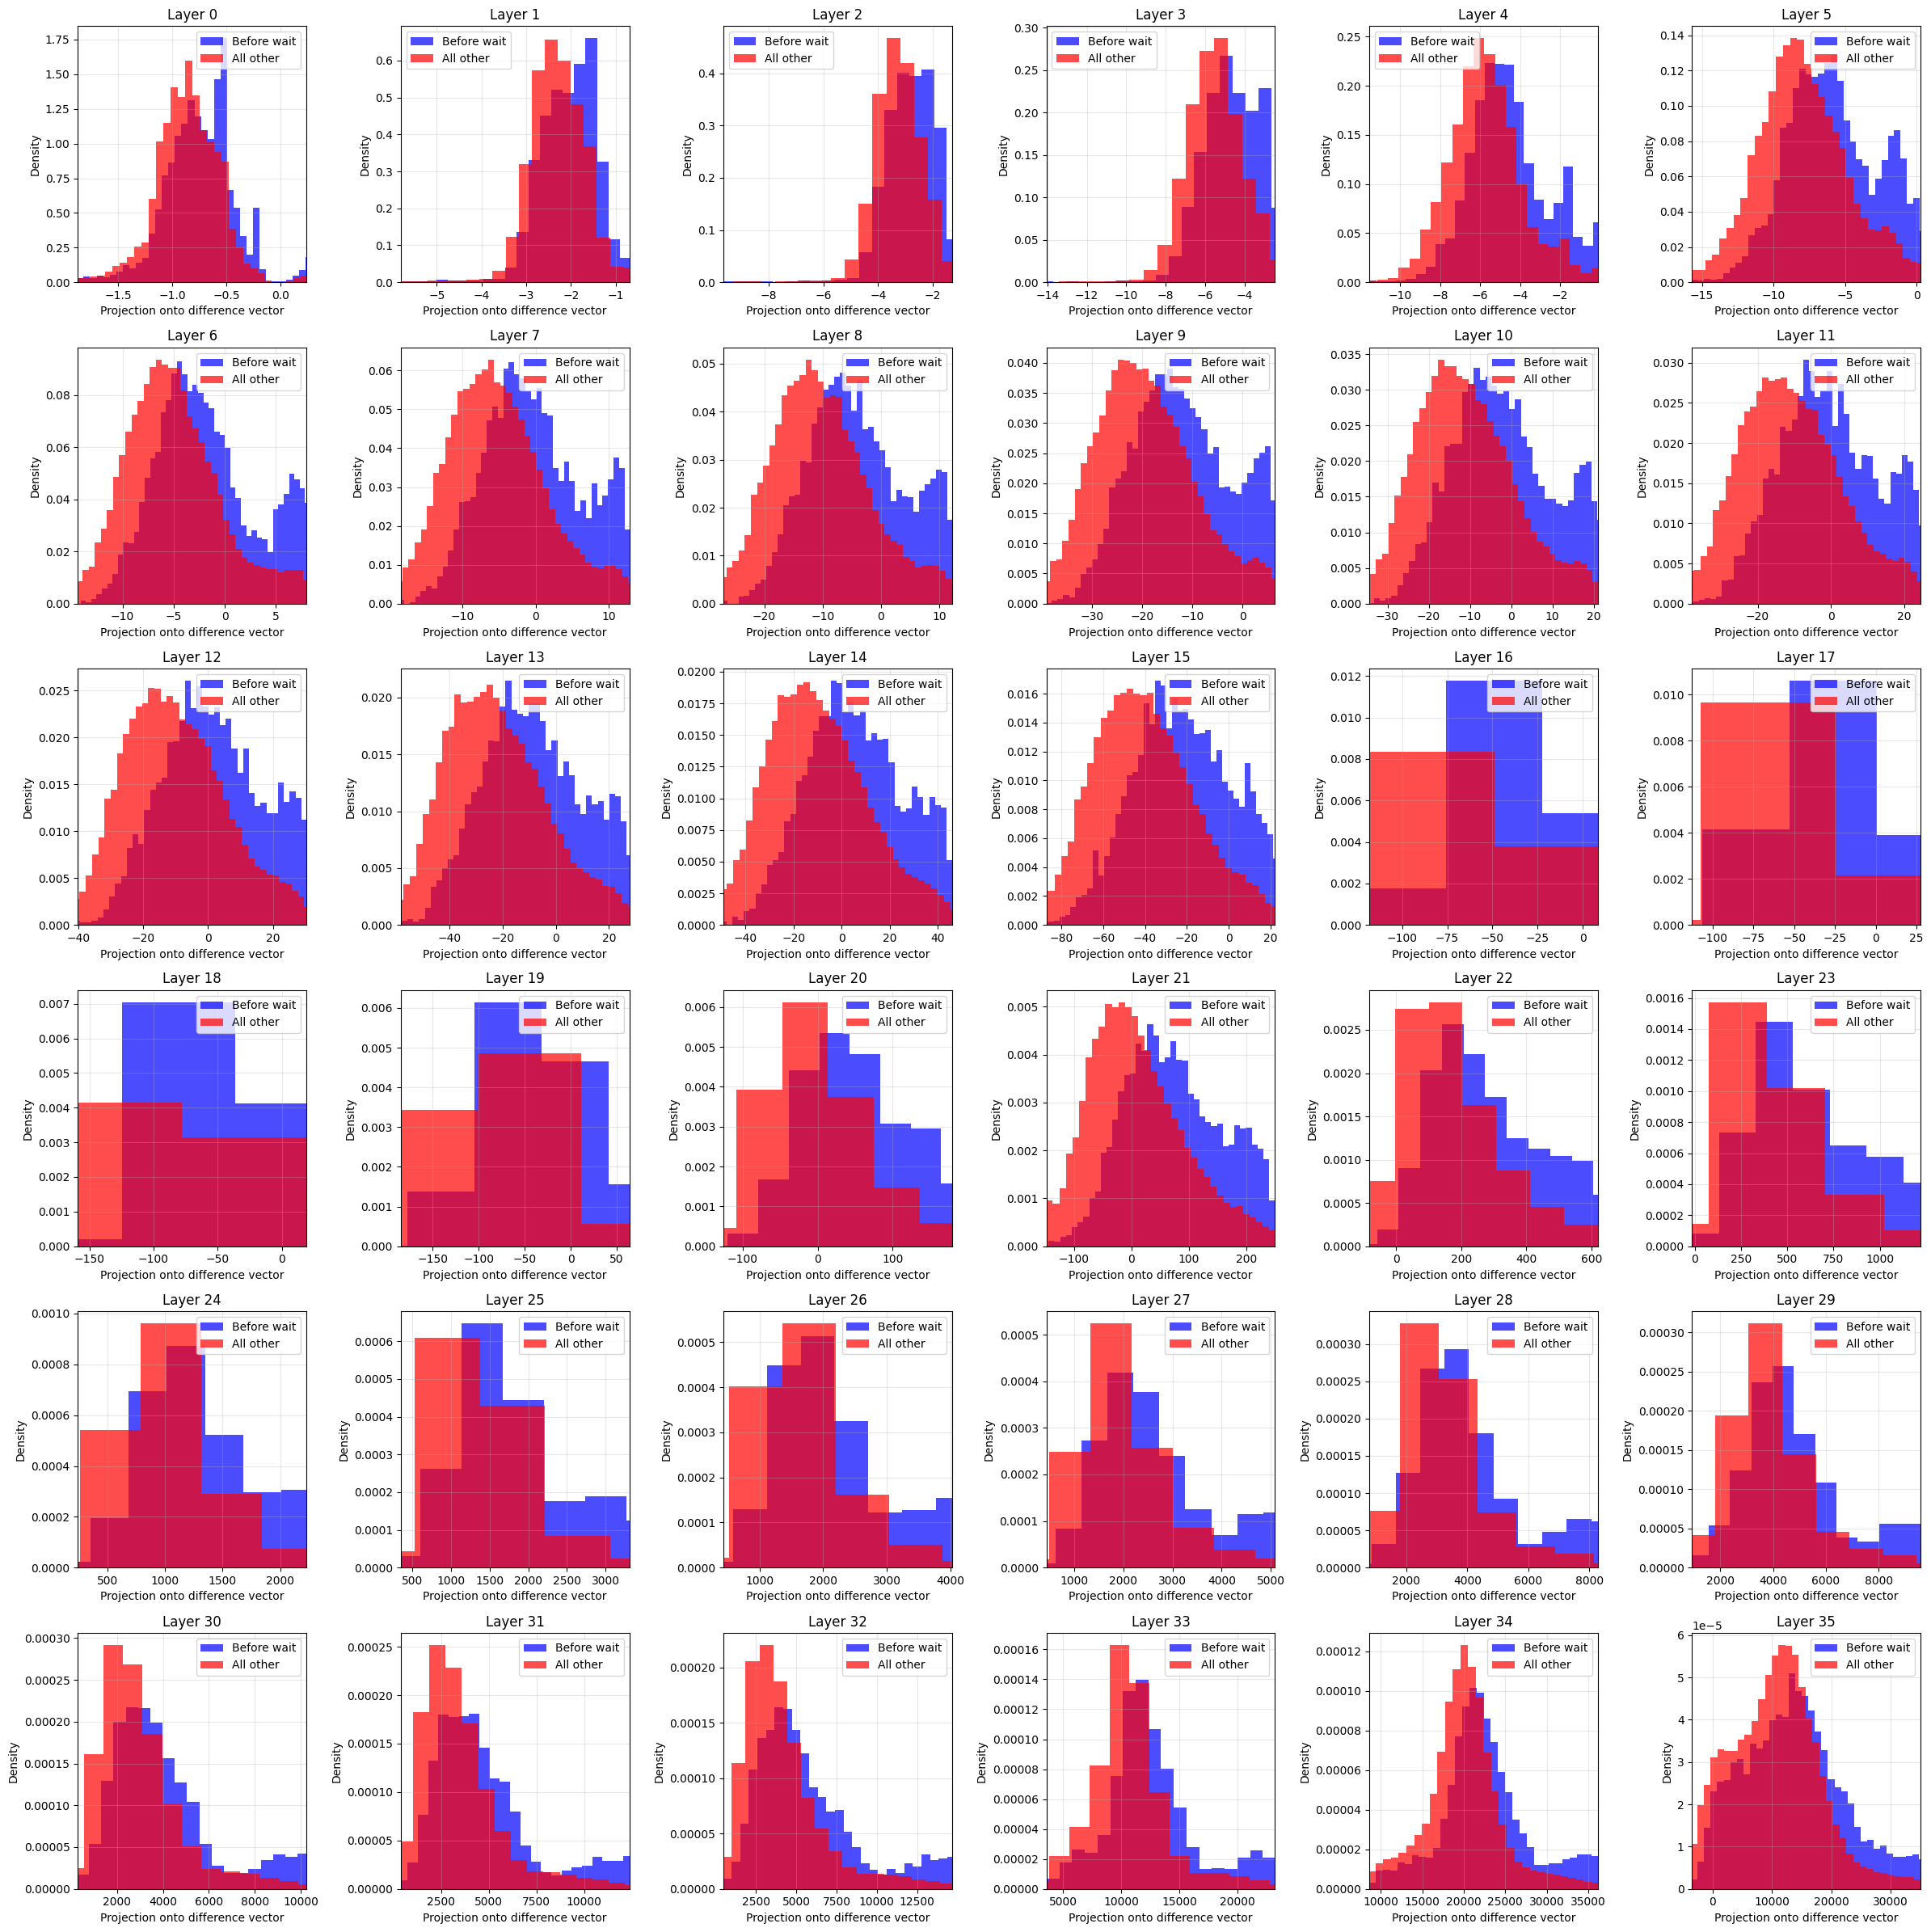

In [168]:
# Create 6x6 subplots for all layers
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
axes = axes.flatten()

for layer_idx in range(36):  # Assuming 36 layers (0-35)
    # Get the difference vector for this layer
    layer_diff_vector = diff_vectors[layer_idx]
    
    # Project the activations onto the difference vector direction
    before_wait_projection = einsum(before_wait_activations[layer_idx].float(), layer_diff_vector.float(), 'b d, d -> b').float()
    all_other_projection = einsum(all_other_activations[layer_idx].float(), layer_diff_vector.float(), 'b d, d -> b').float()
    
    # Combine all projections to calculate 98% range
    all_projections = torch.cat([before_wait_projection, all_other_projection])
    p1, p99 = torch.quantile(all_projections, torch.tensor([0.01, 0.99]).to(all_projections.device))
    
    # Plot on the corresponding subplot
    ax = axes[layer_idx]
    ax.hist(before_wait_projection.cpu().numpy(), bins=50, alpha=0.7, label='Before wait', color='blue', density=True)
    ax.hist(all_other_projection.cpu().numpy(), bins=50, alpha=0.7, label='All other', color='red', density=True)
    ax.set_xlabel('Projection onto difference vector')
    ax.set_ylabel('Density')
    ax.set_title(f'Layer {layer_idx}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(p1.cpu().numpy(), p99.cpu().numpy())

plt.tight_layout()
plt.show()


## eval

In [13]:
import glob

In [14]:
diff_vectors = torch.load('/workspace/basic_science_resampling/data/diff_vectors.pt')

In [ ]:
# Load test set activations and compute AUC for each layer's diff vector
from sklearn.metrics import roc_auc_score
import numpy as np

test_before_wait_activations = []
test_all_other_activations = []

# Load test set activations
for path in glob.glob('/workspace/basic_science_resampling/data/activations/test/*.pt'):
    token_ids, activations = torch.load(path)
    activations = activations.to('cuda')
    before_wait_indices, all_other_indices = get_before_wait_indices(token_ids, n_tokens_before_wait)
    if len(before_wait_indices) > 0:
        before_wait = activations[:,before_wait_indices,:]
        all_other = activations[:,all_other_indices,:]
        test_before_wait_activations.append(before_wait)
        test_all_other_activations.append(all_other)

test_before_wait_activations = torch.cat(test_before_wait_activations, dim=1)
test_all_other_activations = torch.cat(test_all_other_activations, dim=1)



RuntimeError: Expected all tensors to be on the same device, but got mat2 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_bmm)

Layer 0: AUC = 0.5332
Layer 1: AUC = 0.5348
Layer 2: AUC = 0.5487
Layer 3: AUC = 0.5630
Layer 4: AUC = 0.5393
Layer 5: AUC = 0.6150
Layer 6: AUC = 0.5637
Layer 7: AUC = 0.6027
Layer 8: AUC = 0.6266
Layer 9: AUC = 0.6285
Layer 10: AUC = 0.6063
Layer 11: AUC = 0.6725
Layer 12: AUC = 0.6547
Layer 13: AUC = 0.6688
Layer 14: AUC = 0.6844
Layer 15: AUC = 0.6602
Layer 16: AUC = 0.6795
Layer 17: AUC = 0.6745
Layer 18: AUC = 0.6364
Layer 19: AUC = 0.6603
Layer 20: AUC = 0.6300
Layer 21: AUC = 0.6708
Layer 22: AUC = 0.6489
Layer 23: AUC = 0.6455
Layer 24: AUC = 0.6204
Layer 25: AUC = 0.6292
Layer 26: AUC = 0.6433
Layer 27: AUC = 0.6305
Layer 28: AUC = 0.6134
Layer 29: AUC = 0.6039
Layer 30: AUC = 0.5854
Layer 31: AUC = 0.6122
Layer 32: AUC = 0.5969
Layer 33: AUC = 0.5980
Layer 34: AUC = 0.5881
Layer 35: AUC = 0.5633


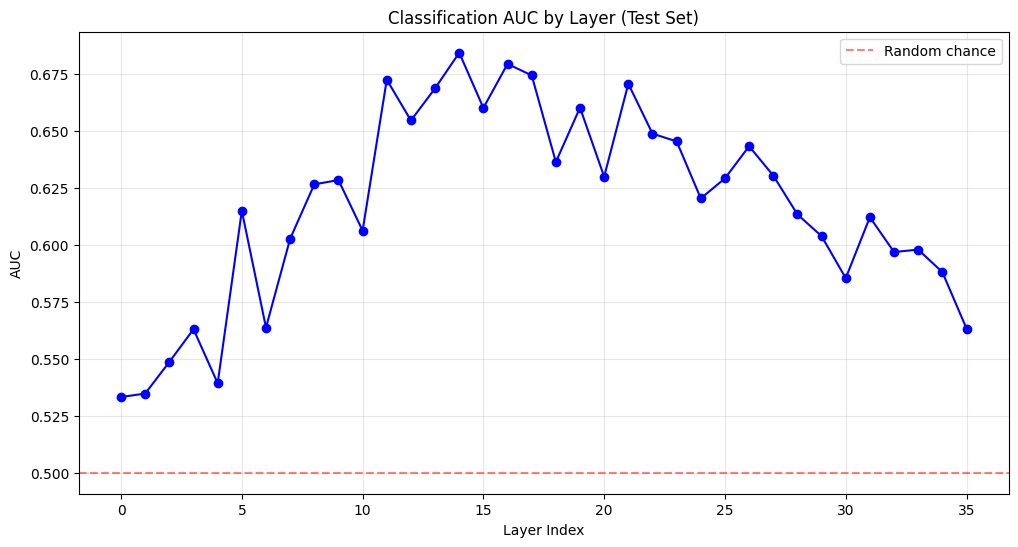


Best layer: 14 with AUC = 0.6844
Mean AUC across all layers: 0.6176


In [20]:
# Compute AUC for each layer
layer_aucs = []
for layer_idx in range(36):
    # Get the difference vector for this layer (trained on train set)
    layer_diff_vector = diff_vectors[layer_idx].to('cuda')
    
    # Project test activations onto the difference vector
    test_before_wait_projection = einsum(test_before_wait_activations[layer_idx].float(), layer_diff_vector.float(), 'b d, d -> b').cpu().numpy()
    test_all_other_projection = einsum(test_all_other_activations[layer_idx].float(), layer_diff_vector.float(), 'b d, d -> b').cpu().numpy()
    
    # Create labels (1 for before_wait, 0 for all_other)
    before_wait_labels = np.ones(len(test_before_wait_projection))
    all_other_labels = np.zeros(len(test_all_other_projection))
    
    # Combine projections and labels
    all_projections = np.concatenate([test_before_wait_projection, test_all_other_projection])
    all_labels = np.concatenate([before_wait_labels, all_other_labels])
    
    # Compute AUC
    auc = roc_auc_score(all_labels, all_projections)
    layer_aucs.append(auc)
    print(f"Layer {layer_idx}: AUC = {auc:.4f}")

# Plot AUC by layer
plt.figure(figsize=(12, 6))
plt.plot(range(36), layer_aucs, 'bo-')
plt.xlabel('Layer Index')
plt.ylabel('AUC')
plt.title('Classification AUC by Layer (Test Set)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random chance')
plt.legend()
plt.show()

print(f"\nBest layer: {np.argmax(layer_aucs)} with AUC = {max(layer_aucs):.4f}")
print(f"Mean AUC across all layers: {np.mean(layer_aucs):.4f}")


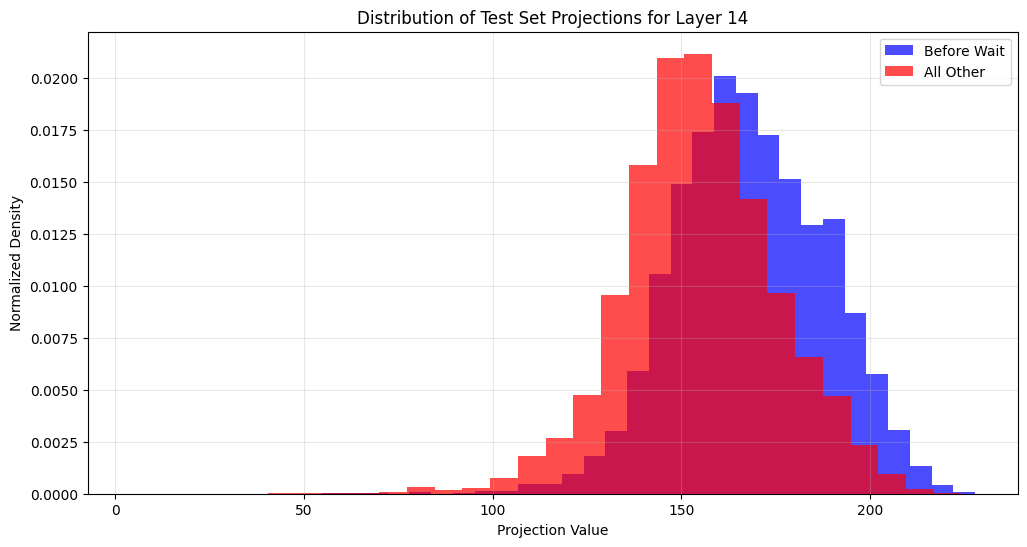

Before Wait - Mean: 168.3315, Std: 19.8498
All Other - Mean: 154.9297, Std: 20.2626


In [21]:
# Visualize distribution of test set projections for layer 14
layer_idx = 14
layer_diff_vector = diff_vectors[layer_idx].to('cuda')

# Project test activations onto the difference vector for layer 14
test_before_wait_projection = einsum(test_before_wait_activations[layer_idx].float(), layer_diff_vector.float(), 'b d, d -> b').cpu().numpy()
test_all_other_projection = einsum(test_all_other_activations[layer_idx].float(), layer_diff_vector.float(), 'b d, d -> b').cpu().numpy()

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(test_before_wait_projection, bins=30, alpha=0.7, label='Before Wait', density=True, color='blue')
plt.hist(test_all_other_projection, bins=30, alpha=0.7, label='All Other', density=True, color='red')
plt.xlabel('Projection Value')
plt.ylabel('Normalized Density')
plt.title(f'Distribution of Test Set Projections for Layer {layer_idx}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Before Wait - Mean: {np.mean(test_before_wait_projection):.4f}, Std: {np.std(test_before_wait_projection):.4f}")
print(f"All Other - Mean: {np.mean(test_all_other_projection):.4f}, Std: {np.std(test_all_other_projection):.4f}")


In [18]:
test_before_wait_activations.device

device(type='cuda', index=0)

In [19]:
layer_diff_vector.device

device(type='cpu')

In [4]:
import nnsight
from nnsight import LanguageModel
import torch
model = LanguageModel(
    'Qwen/Qwen3-8b',
    device_map = 'auto'
)


In [5]:
import json

# Load test rollouts
with open('/workspace/basic_science_resampling/data/test_rollouts.json', 'r') as f:
    test_rollouts = json.load(f)

print(f"Loaded {len(test_rollouts)} test rollouts")


Loaded 300 test rollouts


In [12]:
diff_vectors = torch.load('/workspace/basic_science_resampling/data/diff_vectors.pt').to('cuda')

In [26]:
instruction = "What are some fun things to do in London?" #test_rollouts[2]['instruction']
formatted_instruction = model.tokenizer.apply_chat_template([{'role': 'user', 'content': instruction}], tokenize=False, add_generation_prompt=True)

In [27]:
formatted_instruction

'<|im_start|>user\nWhat are some fun things to do in London?<|im_end|>\n<|im_start|>assistant\n'

In [28]:
start_idx = 0
end_idx = 30

In [29]:
model.model.past_key_values = None
if hasattr(model.model, 'cache'):
    model.model.cache = None
torch.cuda.empty_cache()

In [47]:
with model.generate(formatted_instruction, max_new_tokens=1000,use_cache=True) as tracer:
    with tracer.all():#iter[start_idx:end_idx]:
        model.model.layers[21].output = model.model.layers[21].output +2 * diff_vectors[21]
    output_tokens = tracer.model.generator.output.save()
    print(model.tokenizer.decode(output_tokens[0]))
    print('test')


<|im_start|>user
What are some fun things to do in London?<|im_end|>
<|im_start|>assistant
<think>
Okay, the user is asking for fun things to do in London. Let me start by recalling the main attractions. First, the British Museum is a must-see, but maybe they also want some more unique spots. Wait, the user might be looking for both classic and modern activities. Oh, the Tower of London is a big one. But I should also think about other areas. 

Wait, what about the London Eye? That's a popular spot. But maybe the user is looking for more than just the obvious places. Let me think. Oh, the National Gallery and the Tate Modern are also important. 

Wait, are there any recent attractions? Maybe the London Underground, but that's more of a transportation thing. Or maybe the parks? Hyde Park and Regent's Park. Oh, and the West End for theater. 

Wait, the user might also be interested in shopping. Oxford Street and Bond Street are famous. But maybe they want more cultural stuff. 

Wait, I s

In [42]:
output_str = model.tokenizer.decode(output_tokens[0])[len(formatted_instruction):]

In [43]:
output_str

'<think>\nOkay, the user is asking for fun things to do in London. Let me start by recalling some major attractions.\n\nFirst, the British Museum is a must. It\'s free and has a lot of history. Then there\'s the Tower of London, which is a popular spot with the Crown Jewels. The London Eye is a big attraction too, offering great views. \n\nWait, the user might also like the museums like the Natural History Museum or the Science Museum. Oh, and the Victoria and Albert Museum for art. \n\nWhat about cultural spots? The National Gallery is another one. The Royal Academy of Arts is also worth mentioning. \n\nFor shopping, Oxford Street and Bond Street are famous. Maybe Camden Market for a more eclectic vibe. \n\nEntertainment-wise, West End shows are a big draw. Theaters like the National Theatre. \n\nOh, and the London Underground is a key part of the city\'s transport. Maybe mention the Tube. \n\nWait, the user might also be interested in parks like Hyde Park or Regent\'s Park. \n\nAlso,

In [44]:
from IPython.display import HTML

# Tokenize both the formatted prompt and output
prompt_tokens = [(i,x) for i,x in enumerate(model.tokenizer.tokenize(formatted_instruction))]
output_tokens = [(i+len(prompt_tokens),x) for i,x in enumerate(model.tokenizer.tokenize(output_str))]
all_tokens = prompt_tokens + output_tokens

# Create HTML for tokens with highlighting for positions 60-100
html_content = """
<style>
.token-span {
    font-family: monospace;
    padding: 2px 4px;
    margin: 1px;
    border-radius: 3px;
    display: inline-block;
    color: black;
}
.normal { background-color: #f5f5f5; }
.highlighted { background-color: #ffeb3b; font-weight: bold; }
.prompt { background-color: #e3f2fd; }
</style>
<div>
"""

for i, token in all_tokens:
    # Replace Ġ with space and escape HTML characters in token text
    escaped_token = token.replace('Ġ', ' ').replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')
    
    # Determine color class
    if i < len(prompt_tokens):
        color_class = "prompt"
    elif start_idx <= i < end_idx:
        color_class = "highlighted"
    else:
        color_class = "normal"
    
    html_content += f'<span class="token-span {color_class}">{escaped_token}</span>'

html_content += """
</div>
"""

HTML(html_content)

In [36]:
print(output_str)

<think>
Okay, the user is asking for fun things to do in London. Let me start by recalling the main attractions. First, the British Museum is a must. It's free and has a lot of history. Then there's the Tower of London, which is a historic site with the Crown Jewels. 

Wait, the user might be looking for both historical and modern spots. Maybe I should include some parks too. Hyde Park is a big one, and there's the London Eye. Oh, the London Eye is a great view. 

What about the West End? The theater district is a big draw. Also, the Shard is a modern landmark. Should I mention the museums like the Natural History Museum or the Science Museum? 

Oh, and the museums are free, which is a plus. Then there's the Tate Modern for art. Maybe the National Gallery as well. 

Wait, the user might also like some unique experiences. Like the Harry Potter studio tour? No, that's in Leavesden. Wait, maybe the Warner Bros. Studio Tour? Or is that in another city? 

Also, the Royal Parks are a good id

In [590]:
model.model.past_key_values

## training logistic regression

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from pathlib import Path

# Get train paths
train_activations_dir = Path('/workspace/basic_science_resampling/data/activations/train/')
train_paths = list(train_activations_dir.glob('*.pt'))
print(f"Found {len(train_paths)} train activation files")

# Prepare data for logistic regression
X_list = []
y_list = []

# Process each activation file to collect training data
for path in train_paths[:100]:  # Use subset for faster training
    with torch.no_grad():
        print(f"Processing {path} for logistic regression")
        token_ids, activations = torch.load(path)
        before_wait_indices, all_other_indices = get_before_wait_indices(token_ids, n_tokens_before_wait)
        
        if len(before_wait_indices) > 0:
            # Get activations for each layer
            for layer_idx in range(activations.shape[0]):
                # Before wait tokens (label = 1)
                before_wait_acts = activations[layer_idx, before_wait_indices, :].float()
                X_list.append(before_wait_acts)
                y_list.extend([1] * len(before_wait_acts))
                
                # Sample equal number of other tokens (label = 0)
                n_samples = min(len(before_wait_acts), len(all_other_indices))
                if n_samples > 0:
                    sampled_indices = np.random.choice(all_other_indices, n_samples, replace=False)
                    all_other_acts = activations[layer_idx, sampled_indices, :].float()
                    X_list.append(all_other_acts)
                    y_list.extend([0] * len(all_other_acts))
        
        del activations, token_ids
        gc.collect()

# Combine all data
X = torch.cat(X_list, dim=0)
y = torch.tensor(y_list, dtype=torch.float32)

print(f"Training data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Positive samples: {torch.sum(y)}, Negative samples: {len(y) - torch.sum(y)}")

# Define simple logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Train logistic regression
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LogisticRegression(X.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X = X.to(device)
y = y.to(device)

print("Training logistic regression...")
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X).squeeze()
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate on training data
model.eval()
with torch.no_grad():
    outputs = model(X).squeeze()
    y_pred = (outputs > 0.5).float()
    accuracy = (y_pred == y).float().mean()
    
print(f"Training accuracy: {accuracy:.4f}")

# Get the learned weights as our probe vector
probe_vector = model.linear.weight.squeeze().detach()
print(f"Probe vector shape: {probe_vector.shape}")


Found 1200 train activation files
Processing /workspace/basic_science_resampling/data/activations/train/1199.pt for logistic regression
Processing /workspace/basic_science_resampling/data/activations/train/1198.pt for logistic regression
Processing /workspace/basic_science_resampling/data/activations/train/1197.pt for logistic regression
Processing /workspace/basic_science_resampling/data/activations/train/1196.pt for logistic regression
Processing /workspace/basic_science_resampling/data/activations/train/1195.pt for logistic regression
Processing /workspace/basic_science_resampling/data/activations/train/1194.pt for logistic regression
Processing /workspace/basic_science_resampling/data/activations/train/1193.pt for logistic regression


KeyboardInterrupt: 